In [25]:
import os
import sys
import time

import numpy as np
import torch
from torch import nn
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

class data_preprocess:
    '''''
        Usage:
            Loads the training and test data, breaks them in tiles and standarizes with respect to the training
            data. The images are textfiles in format .dat (whatever it is)

            data_preprocess(data_list,tile_size=80, overlap=44, threshold=6)
                Declares a data preprocessing object
                data_list: list of paths to images by default.
                tile_size, overlap, threshold: parameters of the tiling process.

            load(datatype,num_data='all',datalist='none',randomize=True)
                Loads, tiles and standardizes training or test data
                datatype:  'train' or 'test' Allocates each data in different variables. In training
                           the data is normalized with its mean and std. In test, the train data stats are used.
                numdata:   Number of samples to be read from the datalist. If 'all', the whole list is used.
                datalist:  List of paths to images. If 'none', the default one declared before is used.
                randomize: If true, reads numdata samples at random from the list. Otherwise, it uses the
                           first numdata samples.

            Variables:
                train_tiles
                test_tiles
                test_image_indexes: indexes of the first one of the tiles corresponding to each image. For example,
                                    the tiles of image 0 are located in test_tiles in postions test_image[0]
                                    to test_image[1]-1. Useful to compute the reconstruction error of a given
                                    test image

            Other variables:
                list:               Used data list
                train_images
                test_images
                train_loaded:       Boolean
                test_loaded:        Boolean
                train_standardized: Boolean
                test_standardized:  Boolean
                tile_size
                overlap
                threshold
                mean:               standardization mean
                std:                standardization std

            Example usage
                preprocess=data_preprocess('my_data_list')
                preprocess.load('train',num_data=100)  # Reads 100 data at random from 'my_data_list' and it stores it in
                                                       # preprocess.train_tiles
                preprocess.load('test',num_data=100)   # Reads all the data from 'my_data_list', stores it in
                                                       # preprocess.test_tiles and indexes it in
                                                       # preprocess.test_image_indexes
                preprocess.load('test',datalist='my_image.dat') # Loads a single image in test_tiles.

    '''''
    def __init__(self, data_list, tile_size=80, overlap=44, threshold=6):
        self.train_tiles = None
        self.test_tiles = None
        self.mean = None
        self.std = None
        self.list=data_list
        self.train_loaded=False
        self.test_loaded=False
        self.train_standardized=False
        self.test_standardized=False
        self.tile_size=tile_size
        self.overlap = overlap
        self.step = None
        self.threshold=threshold
        self.train_images = None

    def standardize(self, datatype):
        if datatype == 'train':
            T_train_data = torch.from_numpy(self.train_tiles).float()
            self.mean = T_train_data.mean().numpy()
            self.std = T_train_data.std().numpy()

            self.train_tiles = (self.train_tiles - self.mean) / self.std
            self.train_standardized = True

        if datatype == 'test':
            if self.train_standardized:
                self.test_tiles = (self.test_tiles - self.mean) / self.std
                self.test_standardized = True


    def tile_image(self, image):
        height, width = image.shape[:2]
        if self.step is None:
            self.step = self.tile_size - self.overlap
        if (height - self.overlap) / self.step != np.ceil((height - self.overlap) / self.step): # Checks that the parameters are correct. If not, shows a list of acceptable overlaps for the specified tile size.
            print("The overlaps for a tile size of " + str(self.tile_size) + " can only be:")
            for w in range(1, self.tile_size):
                if (height-w) / (self.tile_size - w) == np.ceil((height - w) / (self.tile_size - w)):
                    print(w)
            sys.exit("")
        tiles = []
        for y in range(0, height - self.overlap, self.step):
            for x in range(0, width - self.overlap, self.step):
                tile = image[y:min(y + self.tile_size, height), x:min(x + self.tile_size, width)]
                I = tile.reshape(self.tile_size ** 2, 1)
                z = np.zeros(I.shape)
                m = np.median(I)
                z[np.argwhere(I>3*m)]=1
                mean = np.sum(z)
                if mean >= self.threshold:
                    tiles.append(tile)
        return tiles

    def tile_data(self, datatype):
        if datatype == 'train':
            images = self.train_images
        else:
            images = self.test_images
            test_image_indexes=[0]

        height, width = images.shape[:2]
        N = images.shape[2]
        self.step = self.tile_size - self.overlap
        process_time = AlgorithmTimer(N)
        max_num_tiles = int(((height - self.overlap) / self.step) ** 2)
        temp_tiles = np.zeros((max_num_tiles * N, self.tile_size, self.tile_size))
        index = 0
        process_time.restart(N)

        for i in range(N):
            image = images[:,:,i]
            tiles = self.tile_image(image)
            x = np.array(tiles)
            number_of_tiles = len(tiles)
            temp_tiles[index:index+number_of_tiles,:,:] = x
            index = index + number_of_tiles
            if datatype == 'test':
                test_image_indexes.append(index)
            message="Tiling, "+str(i+1)+"/"+str(N)+'('+ str(number_of_tiles)+ ')'
            process_time.show_time(message)
        print("                                                                                                \r",end='',flush=True)
        print("Number of "+datatype+" tiles: "+str(index))

        if datatype == 'train':
            self.train_tiles = temp_tiles[:index, :, :]
        else:
            self.test_tiles = temp_tiles[:index, :, :]
            self.test_image_indexes = test_image_indexes

    def load(self, datatype, num_data: str | int, datalist='none', randomize=True):
        if datalist=='none':
            t_list = self.list
        else:
            t_list = datalist
        if num_data == 'all':
            num_data = len(t_list)

        f = t_list[0]
        image = np.genfromtxt(f)
        size = image.shape[0]
        if randomize:
            Ind = np.random.choice(len(t_list), size=num_data, replace=False)
        else:
            Ind = range(num_data)
        images = np.zeros((size,size,num_data))
        process_time = AlgorithmTimer(num_data)
        for i,ind in enumerate(Ind):
            f = t_list[ind]
            images[:,:,i] = np.genfromtxt(f)
            process_time.show_time('Reading images. ')

        if datatype == 'train':
            self.train_loaded=True
            self.train_images = images
        if datatype == 'test':
            self.test_loaded=True
            self.test_images = images

        self.tile_data(datatype)
        self.standardize(datatype)

class Autoencoder2(nn.Module): #We call this autoencoder 2
    def __init__(self, dropout_rate=0.2):
        super(Autoencoder2, self).__init__()

        self.dropout_rate = dropout_rate
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=5, padding=0),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=4, padding=0),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=4, padding=0),
            nn.ReLU(),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        xb = self.encoder(x)
        x = self.decoder(xb)
        return x, xb

class AlgorithmTimer:
    def __init__(self, num_iterations):
        self.start_time = None
        self.end_time = None
        self.elapsed_time = None
        self.iteration = 0
        self.total_time = 0
        self.num_iterations = num_iterations
    sround = lambda x,p: float(f'%ds.{p-1}e'%x) # This is to print numbers with a given number od decimals
    def start(self):
        self.start_time = time.time()

    def end(self):
        self.end_time = time.time()
        self.elapsed_time = self.end_time - self.start_time

    def restart(self, num_iterations):
        self.start_time = None
        self.end_time = None
        self.elapsed_time = None
        self.iteration = 0
        self.total_time = 0
        self.num_iterations = num_iterations

    def hms(self,t):
        h=np.floor(t/3600)
        t=t-h*3600
        m=np.min([59,np.floor(t/60)])
        s=np.min([59,t-m*60])
        h_str=f'{h:.0f}'
        m_str=f'{m:.0f}'
        if np.floor(m)<=9:
            m_str=f'0{np.floor(m):.0f}'
        s_str = f'{s:.0f}'
        if np.floor(s)<=9:
            s_str = f'0{np.floor(s):.0f}'
        time_str = h_str + ':' + m_str + ':' + s_str
        return time_str

    def show_time(self, message=''):
        if self.start_time is not None:
            self.iteration=self.iteration+1
            self.end()
            self.total_time=self.total_time+self.elapsed_time
            t=self.elapsed_time
            T=self.num_iterations*self.total_time/self.iteration
            total_time = self.hms(T)
            RT=T-self.total_time
            remaining_time=self.hms(RT)
            print(message + f' Iteration time: {round(t, 2):.2f} s. Total time: ' + total_time + '. Remaining time: ' + remaining_time + '           \r', end='', flush=True)
        self.start()

    def total_time(self):
        if self.start_time is not None:
            return self.total_time
        return None

    def show_total_time(self):
        if self.start_time is not None:
            timestr=self.hms(self.total_time)
            print("Total time: " +timestr+"                                    " )
            return self.total_time
        return None

# Load Data

In [26]:
data_path = 'data'

# List of data
data_list = []
for filename in os.listdir(data_path):
    if filename.endswith(".dat"):
        data_list.append(os.path.join(data_path, filename))

# Data Preprocessing

In [27]:
# Parameters of the training
tile_size = 80
overlap = 44
threshold = 10
batch_size = 32
input_shape = (tile_size, tile_size, 1)
model = Autoencoder2()
summary(model, input_size=(1, tile_size, tile_size))
N_train = 500 # This is the number of training data (we choose later the first N_train images)
N_test = 100
# With N_train = 146 we get 10,000 tiles of 80x80 and overlap 44

preprocess = data_preprocess(data_list=data_list, tile_size=tile_size, overlap=overlap, threshold=threshold)
preprocess.load('train', randomize=True, num_data=N_train)
train_data = preprocess.train_tiles

preprocess.load('test', randomize=True, num_data=N_test)
val_data = preprocess.test_tiles

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]             640
              ReLU-2           [-1, 64, 80, 80]               0
         MaxPool2d-3           [-1, 64, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          73,856
              ReLU-5          [-1, 128, 20, 20]               0
         MaxPool2d-6            [-1, 128, 5, 5]               0
            Conv2d-7            [-1, 256, 5, 5]         295,168
              ReLU-8            [-1, 256, 5, 5]               0
         MaxPool2d-9            [-1, 256, 1, 1]               0
  ConvTranspose2d-10            [-1, 128, 5, 5]         819,328
             ReLU-11            [-1, 128, 5, 5]               0
  ConvTranspose2d-12           [-1, 64, 20, 20]         131,136
             ReLU-13           [-1, 64, 20, 20]               0
  ConvTranspose2d-14           [-1, 32,

In [ ]:
# Convert data to PyTorch tensors and reshape for (N, C, H, W)
train_tensor = torch.tensor(train_data).unsqueeze(1).float()
val_tensor = torch.tensor(val_data).unsqueeze(1).float()

# DataLoader
train_loader = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor, val_tensor), batch_size=batch_size)

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        output, _ = model(x)
        loss = criterion(output, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            output, _ = model(x)
            loss = criterion(output, x)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")



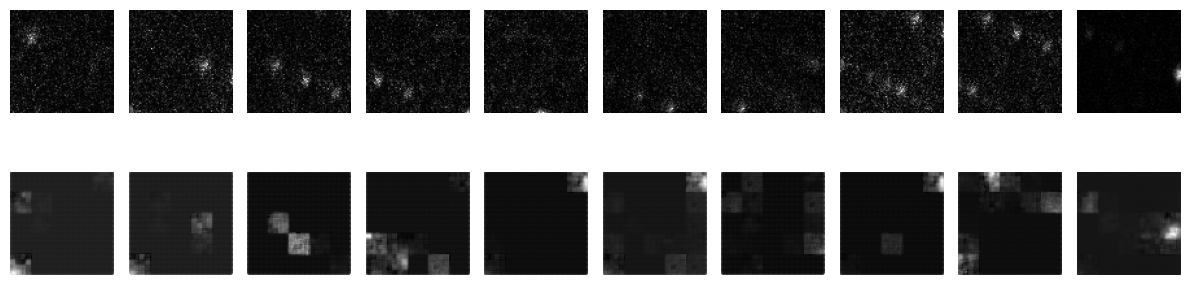

In [16]:
import matplotlib.pyplot as plt

# Use model in eval mode
model.eval()

# Take a batch from validation set
with torch.no_grad():
    val_batch = next(iter(val_loader))[0].to(device)
    reconstructed, _ = model(val_batch)

# Move to CPU for plotting
original = val_batch.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

# Plot first 6 tiles
n = 10
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i][0], cmap='gray')
    # plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i][0], cmap='gray')
    # plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

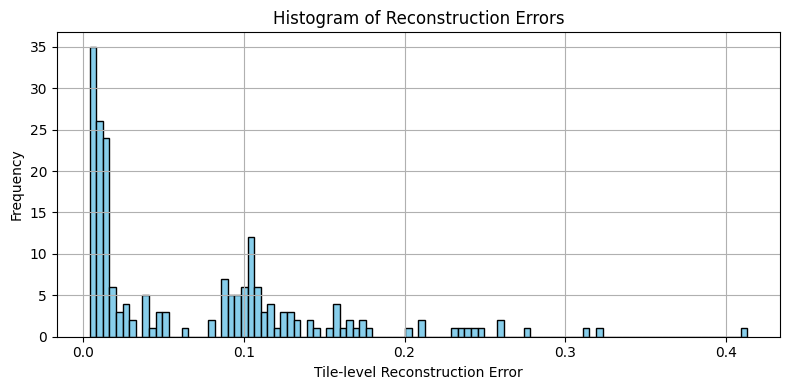

In [18]:
import matplotlib.pyplot as plt

# val_tensor: shape (N, 1, 80, 80) from validation
model.eval()
with torch.no_grad():
    recon_batch, _ = model(val_tensor.to(device))
    recon_batch = recon_batch.cpu().numpy()
    original = val_tensor.cpu().numpy()

# Compute MSE per tile (reconstruction error)
errors = ((original - recon_batch) ** 2).mean(axis=(1, 2, 3))  # shape: (N,)

# Plot histogram (e.g., 50 bins)
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Tile-level Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.grid(True)
plt.tight_layout()
plt.show()
